# Mobile-Net_V1
- landmark 분류 모델

In [1]:
from keras import models, layers
from keras import Input
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, DepthwiseConv2D, Conv2D, Activation, Dense
from keras.layers import GlobalAveragePooling2D, ZeroPadding2D, Reshape, Dropout
 

import os
import matplotlib.pyplot as plt
import numpy as np
import math
 

    
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
 

train_dir = os.path.join('학습 이미지 클래스 경로')
val_dir = os.path.join('검증 이미지 클래스 경로')
 

train_generator = train_datagen.flow_from_directory(train_dir, batch_size=16, target_size=(224, 224), color_mode='rgb')
val_generator = val_datagen.flow_from_directory(val_dir, batch_size=16, target_size=(224, 224), color_mode='rgb')

def depthwise_bn_relu(x, s, padd):
    x = DepthwiseConv2D((3, 3), strides=(s, s), padding=padd, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x
 
def pointwise_bn_relu(x, number_of_filter):
    x = Conv2D(number_of_filter, (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x
 

input_tensor = Input(shape=(224, 224, 3), dtype='float32', name='input')
 
x = ZeroPadding2D(padding=((0, 1), (0, 1)))(input_tensor)
x = Conv2D(32, (3, 3), strides=(2, 2), padding='valid', use_bias=False)(x)
 
x = BatchNormalization()(x)
x = Activation('relu')(x)
 
x = depthwise_bn_relu(x, 1, 'same')
x = pointwise_bn_relu(x, 64)
x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
 

x = depthwise_bn_relu(x, 2, 'valid')
x = pointwise_bn_relu(x, 128)
 
x = depthwise_bn_relu(x, 1, 'same')
x = pointwise_bn_relu(x, 128)
x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
 
x = depthwise_bn_relu(x, 2, 'valid')
x = pointwise_bn_relu(x, 256)
 
x = depthwise_bn_relu(x, 1, 'same')
x = pointwise_bn_relu(x, (256))
x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
 
x = depthwise_bn_relu(x, 2, 'valid')
x = pointwise_bn_relu(x, 512)
 
for _ in range(5):
    x = depthwise_bn_relu(x, 1, 'same')
    x = pointwise_bn_relu(x, 512)
x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
 
x = depthwise_bn_relu(x, 2, 'valid')
x = pointwise_bn_relu(x, 1024)
 
x = depthwise_bn_relu(x, 2, 'same')
x = pointwise_bn_relu(x, 1024)
 
x = GlobalAveragePooling2D()(x)
x = Reshape((1, 1, 1024))(x)
x = Dropout(0.001)(x)
x = Conv2D(392, (1, 1), strides=(1, 1), padding='same')(x)
x = Activation('softmax')(x)

# 이미지 클래스 개수 (예: 392곳의 랜드마크)
output_tensor = Reshape((392,))(x)

my_mobile = Model(input_tensor, output_tensor)
my_mobile.summary()
 

Using TensorFlow backend.


Found 31360 images belonging to 392 classes.
Found 3920 images belonging to 392 classes.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 225, 225, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      864       
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 32)      0         
_________________________________________________________________
depthwise_conv2d_1 (Depthwis (None, 112, 112, 32)      288       
____________________________________

In [2]:
import keras
my_mobile.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [3]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=100)

In [4]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                           patience=30,
                                           verbose=1,
                                           factor=0.5,
                                            min_lr=0.00001)

In [5]:
callbacks=[earlystop, learning_rate_reduction]

In [6]:
history=my_mobile.fit_generator(
        train_generator,
        steps_per_epoch=15,
        epochs=100000,
        validation_data=val_generator,
        validation_steps=5,
        callbacks=callbacks
        )

Epoch 1/100000
15/15 [==============================] - 10s 697ms/step - loss: 6.7418 - accuracy: 0.0083 - val_loss: 5.9444 - val_accuracy: 0.0000e+00
Epoch 2/100000
15/15 [==============================] - 2s 135ms/step - loss: 6.6561 - accuracy: 0.0083 - val_loss: 6.0178 - val_accuracy: 0.0000e+00
Epoch 3/100000
15/15 [==============================] - 2s 136ms/step - loss: 6.5354 - accuracy: 0.0083 - val_loss: 6.0553 - val_accuracy: 0.0000e+00
Epoch 4/100000
15/15 [==============================] - 2s 155ms/step - loss: 6.2712 - accuracy: 0.0000e+00 - val_loss: 6.0953 - val_accuracy: 0.0125
Epoch 5/100000
15/15 [==============================] - 3s 181ms/step - loss: 6.3580 - accuracy: 0.0000e+00 - val_loss: 6.0120 - val_accuracy: 0.0000e+00
Epoch 6/100000
15/15 [==============================] - 3s 176ms/step - loss: 6.1727 - accuracy: 0.0042 - val_loss: 6.2351 - val_accuracy: 0.0000e+00
Epoch 7/100000
15/15 [==============================] - 3s 177ms/step - loss: 6.1828 - accuracy

15/15 [==============================] - 3s 176ms/step - loss: 5.1437 - accuracy: 0.0375 - val_loss: 6.4642 - val_accuracy: 0.0500
Epoch 56/100000
15/15 [==============================] - 3s 180ms/step - loss: 5.1483 - accuracy: 0.0167 - val_loss: 5.9409 - val_accuracy: 0.0625
Epoch 57/100000
15/15 [==============================] - 3s 173ms/step - loss: 5.1301 - accuracy: 0.0417 - val_loss: 5.6976 - val_accuracy: 0.0250
Epoch 58/100000
15/15 [==============================] - 3s 174ms/step - loss: 5.1746 - accuracy: 0.0208 - val_loss: 5.5634 - val_accuracy: 0.0250
Epoch 59/100000
15/15 [==============================] - 3s 175ms/step - loss: 5.0004 - accuracy: 0.0500 - val_loss: 5.6514 - val_accuracy: 0.0375
Epoch 60/100000
15/15 [==============================] - 3s 181ms/step - loss: 5.1008 - accuracy: 0.0333 - val_loss: 5.8184 - val_accuracy: 0.0125
Epoch 61/100000
15/15 [==============================] - 3s 178ms/step - loss: 4.9946 - accuracy: 0.0542 - val_loss: 5.0043 - val_accu

Epoch 111/100000
15/15 [==============================] - 3s 172ms/step - loss: 3.9375 - accuracy: 0.1792 - val_loss: 4.1844 - val_accuracy: 0.2000
Epoch 112/100000
15/15 [==============================] - 3s 175ms/step - loss: 4.0635 - accuracy: 0.1750 - val_loss: 3.4609 - val_accuracy: 0.2500
Epoch 113/100000
15/15 [==============================] - 3s 169ms/step - loss: 4.0175 - accuracy: 0.1750 - val_loss: 3.6256 - val_accuracy: 0.1750
Epoch 114/100000
15/15 [==============================] - 3s 176ms/step - loss: 3.9022 - accuracy: 0.2000 - val_loss: 4.7736 - val_accuracy: 0.1375
Epoch 115/100000
15/15 [==============================] - 3s 175ms/step - loss: 3.9149 - accuracy: 0.2250 - val_loss: 5.0205 - val_accuracy: 0.1250
Epoch 116/100000
15/15 [==============================] - 3s 169ms/step - loss: 4.0885 - accuracy: 0.1625 - val_loss: 3.7889 - val_accuracy: 0.1125
Epoch 117/100000
15/15 [==============================] - 3s 173ms/step - loss: 3.8618 - accuracy: 0.1833 - val_

15/15 [==============================] - 3s 171ms/step - loss: 2.0321 - accuracy: 0.5500 - val_loss: 3.5782 - val_accuracy: 0.3500
Epoch 222/100000
15/15 [==============================] - 3s 170ms/step - loss: 2.2690 - accuracy: 0.4458 - val_loss: 3.0190 - val_accuracy: 0.2875
Epoch 223/100000
15/15 [==============================] - 3s 177ms/step - loss: 2.0436 - accuracy: 0.5208 - val_loss: 2.4558 - val_accuracy: 0.3250
Epoch 224/100000
15/15 [==============================] - 3s 172ms/step - loss: 1.9857 - accuracy: 0.5375 - val_loss: 3.4689 - val_accuracy: 0.3000
Epoch 225/100000
15/15 [==============================] - 3s 173ms/step - loss: 2.3651 - accuracy: 0.4500 - val_loss: 2.9168 - val_accuracy: 0.3875
Epoch 226/100000
15/15 [==============================] - 3s 178ms/step - loss: 2.0437 - accuracy: 0.5292 - val_loss: 1.8695 - val_accuracy: 0.5250
Epoch 227/100000
15/15 [==============================] - 3s 170ms/step - loss: 2.1690 - accuracy: 0.5083 - val_loss: 2.6332 - va

Epoch 276/100000
15/15 [==============================] - 3s 174ms/step - loss: 1.5932 - accuracy: 0.6667 - val_loss: 1.0222 - val_accuracy: 0.7375
Epoch 277/100000
15/15 [==============================] - 3s 176ms/step - loss: 1.2294 - accuracy: 0.7208 - val_loss: 1.3696 - val_accuracy: 0.6875
Epoch 278/100000
15/15 [==============================] - 3s 173ms/step - loss: 1.1579 - accuracy: 0.7542 - val_loss: 2.0054 - val_accuracy: 0.6125
Epoch 279/100000
15/15 [==============================] - 3s 177ms/step - loss: 1.4024 - accuracy: 0.6875 - val_loss: 0.9239 - val_accuracy: 0.6875
Epoch 280/100000
15/15 [==============================] - 3s 169ms/step - loss: 1.1712 - accuracy: 0.7250 - val_loss: 1.0290 - val_accuracy: 0.7250
Epoch 281/100000
15/15 [==============================] - 3s 176ms/step - loss: 1.3195 - accuracy: 0.7250 - val_loss: 1.7139 - val_accuracy: 0.6250
Epoch 282/100000
15/15 [==============================] - 3s 171ms/step - loss: 1.1580 - accuracy: 0.7000 - val_

Epoch 331/100000
15/15 [==============================] - 3s 171ms/step - loss: 1.1301 - accuracy: 0.7375 - val_loss: 1.0185 - val_accuracy: 0.7875
Epoch 332/100000
15/15 [==============================] - 3s 171ms/step - loss: 1.1796 - accuracy: 0.7375 - val_loss: 1.1152 - val_accuracy: 0.6750
Epoch 333/100000
15/15 [==============================] - 3s 175ms/step - loss: 1.2410 - accuracy: 0.7292 - val_loss: 1.6378 - val_accuracy: 0.6750
Epoch 334/100000
15/15 [==============================] - 3s 177ms/step - loss: 0.9585 - accuracy: 0.7750 - val_loss: 1.1738 - val_accuracy: 0.6625
Epoch 335/100000
15/15 [==============================] - 3s 173ms/step - loss: 1.1522 - accuracy: 0.6958 - val_loss: 0.9864 - val_accuracy: 0.7000
Epoch 336/100000
15/15 [==============================] - 3s 173ms/step - loss: 1.0269 - accuracy: 0.7792 - val_loss: 1.3198 - val_accuracy: 0.7125
Epoch 337/100000
15/15 [==============================] - 3s 176ms/step - loss: 1.0995 - accuracy: 0.7375 - val_

Epoch 386/100000
15/15 [==============================] - 3s 167ms/step - loss: 1.0911 - accuracy: 0.7375 - val_loss: 0.4265 - val_accuracy: 0.8250
Epoch 387/100000
15/15 [==============================] - 3s 173ms/step - loss: 0.8204 - accuracy: 0.8292 - val_loss: 0.1618 - val_accuracy: 0.8250
Epoch 388/100000
15/15 [==============================] - 3s 179ms/step - loss: 1.0882 - accuracy: 0.7792 - val_loss: 0.6430 - val_accuracy: 0.7875
Epoch 389/100000
15/15 [==============================] - 3s 184ms/step - loss: 0.9400 - accuracy: 0.8000 - val_loss: 1.4225 - val_accuracy: 0.7125
Epoch 390/100000
15/15 [==============================] - 3s 169ms/step - loss: 0.9121 - accuracy: 0.8000 - val_loss: 0.7241 - val_accuracy: 0.8125
Epoch 391/100000
15/15 [==============================] - 3s 175ms/step - loss: 0.9756 - accuracy: 0.7750 - val_loss: 0.4700 - val_accuracy: 0.7750
Epoch 392/100000
15/15 [==============================] - 2s 159ms/step - loss: 1.1017 - accuracy: 0.7625 - val_

# 훈련 결과

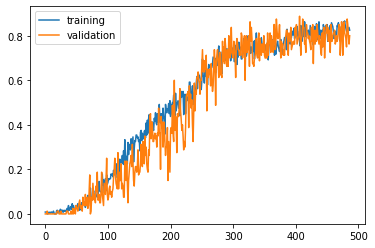

In [7]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'], loc = 'upper left')
plt.show()

In [8]:
history.history['val_accuracy'].index(max(history.history['val_accuracy']))

406

In [9]:
max(history.history['val_accuracy'])

0.887499988079071

In [11]:
history.history['accuracy'].index(max(history.history['accuracy']))

478

In [12]:
max(history.history['accuracy'])

0.8666667

- epochs 487 수행 (최고 accuracy : 0.8666667 -479 Eopoch / 최고 val_accuracy : 0.887499988079071-406 epoch)

# 모델 저장

In [13]:
my_mobile.save("mobile.h5")

In [14]:
my_mobile.save_weights("mobile_weight.h5")

# 모델 불러오기

In [15]:
from keras.models import load_model

In [17]:
model = load_model('mobile.h5')